In [139]:
## Imports
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import json
import matplotlib.pyplot as plt
import glob
import os
import requests
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.externals import *
from dateutil.parser import parse
import datetime as dt
pd.options.mode.chained_assignment = None  # default='warn'

# Exploration
#### This notebook outlines initial exploration of the dataset.

## Task 1: Explore subjects feature
We want to answer some basic questions about the subject feature. This might expose interesting topics to analyze in greater depth. This creates multiple descriptive sub-tasks. We break this task down into the follow sub-tasks:
- Find all unique subjects. How many different subjects are there? (what level of granularity are we getting here?)
- Find which subjects have more than 100 instances within the dataset.
- Find a way to visualize how truth relates to this feature.

In [2]:
## Define paths
DATA_FOLDER = './liar_dataset/'
DATA_PATH = DATA_FOLDER + 'train.tsv'

In [3]:
## Load raw data
cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
    
df_raw = pd.read_table(DATA_PATH, header=None)
df_raw.columns = cols
df_raw.head(2)

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


In [4]:
## Check types and shape
print(df_raw.dtypes)
print(df_raw.shape)

ID                    object
label                 object
statement             object
subject               object
speaker               object
job                   object
state                 object
party                 object
barely_true_cts      float64
false_cts            float64
half_true_cts        float64
mostly_true_cts      float64
pants_on_fire_cts    float64
context               object
dtype: object
(10240, 14)


In [5]:
## Help put data in useful form - split topics as list and separate into new rows for grouping
## Split subjects into lists
subject_split = df_raw.copy()
subject_split["subject"] = df_raw["subject"].apply(lambda x : str(x).lower().split(","))
subject_split.head(2)

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,[abortion],dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


In [6]:
set_of_subjects = set()
for subject_list in subject_split['subject'].values:
    set_of_subjects |= set(subject_list)
    
print("There are %d unique subjects" % len(set_of_subjects))
print("Some sample subjects include:\n", list(set_of_subjects)[:5])

There are 143 unique subjects
Some sample subjects include:
 ['religion', 'voting-record', 'diversity', 'pundits', 'sexuality']


In [7]:
## Create a dataframe of all subjects
subjects = subject_split.subject.apply(pd.Series)
new_cols = cols.copy()
new_cols.remove("subject")

## Now merge with original frame to create separate columns for each subject
## Then melt so that each entry exists under several subjects
subject_split = subjects.merge(subject_split, right_index = True, left_index = True) \
    .drop(["subject"], axis = 1) \
    .melt(id_vars = new_cols, value_name = "subject") \
    .drop("variable", axis = 1) \
    .dropna()

subject_split.head(2)

,ID,label,statement,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context,subject
0,2635.json,false,Says the Annies List political group supports ...,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,abortion
1,10540.json,half-true,When did the decline of coal start? It started...,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,energy


We notice that many subjects have very few instances within the dataset. 
We want to limit ourselves to subjects that are mentioned with reasonable frequency.
We choose to only include subjects that appear more than 100 times.

In [8]:
subject_counts = subject_split.groupby("subject").count()
subjects_over_100 = subject_counts.where(subject_counts['ID'] > 100).dropna().index
subject_split = subject_split[subject_split['subject'].isin(subjects_over_100)]

print("There are %d unique subjects that have over 100 corresponding statements" % len(subjects_over_100))

There are 44 unique subjects that have over 100 corresponding statements


By limiting out subjects to those that appear frequently, we have a small enough set to do some useful visual analysis.

In [9]:
def by_label(df, column):
    return df.groupby([column,"label"]).agg({"ID" : "count"})

breakdown = by_label(subject_split, 'subject')
breakdown.head()

ID
subject  label          
abortion barely-true  30
         false        23
         half-true    31
         mostly-true  20
         pants-fire   10

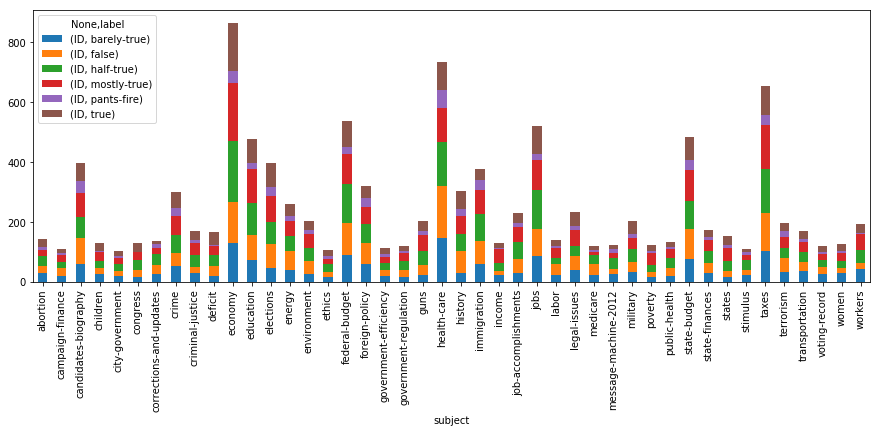

In [10]:
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [174]:
def normalize(df, column):
    bd_norm = df.reset_index()
    bd_norm = bd_norm.set_index([column,'label'])['ID'].unstack(fill_value=0)

    row_sums = bd_norm.sum(axis=1)
    for row_ind in range(len(bd_norm.index)):
        bd_norm.iloc[row_ind] /= row_sums[row_ind]

    bd_norm = bd_norm.stack().reset_index(name='Percent').set_index([column, 'label'])
    return bd_norm

bd_norm = normalize(breakdown, 'subject')

KeyError: 'subject'

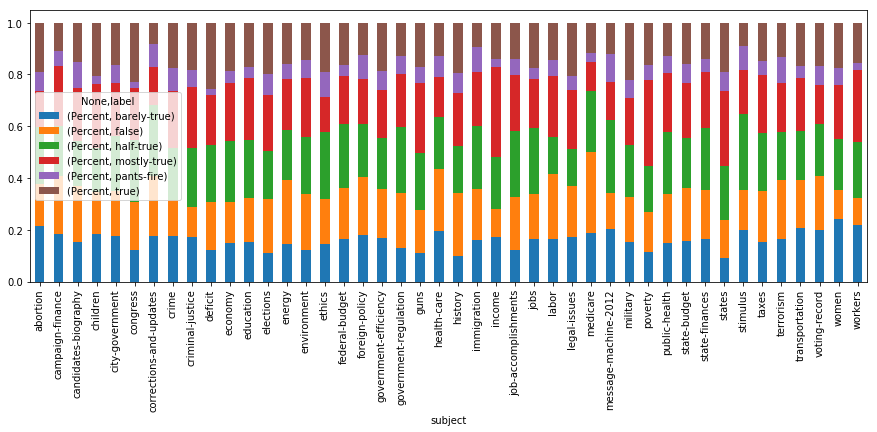

In [12]:
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

Above, we can see from our un-normalized plot the distribution of topics as well as their respective distribution of truth classifications. From the normalized plot, we see can more easily see the distribution of truth classifications.

We may be interested in making a simpler classification, such as 'false' versus 'not false'. In this way, we regard 'pants-fire' and 'false' as a false tags, and all others are those statements with at least a small degree of truth within.

In [13]:
def transform_tf(df, column):
    tf_breakdown = df.copy()
    tf_breakdown['false'] = ~(tf_breakdown['label'].isin(['false', 'pants-fire']))

    tf_breakdown = tf_breakdown.groupby([column,"false"]).agg({"ID" : "count"})
    return tf_breakdown

tf_breakdown = transform_tf(subject_split, 'subject')

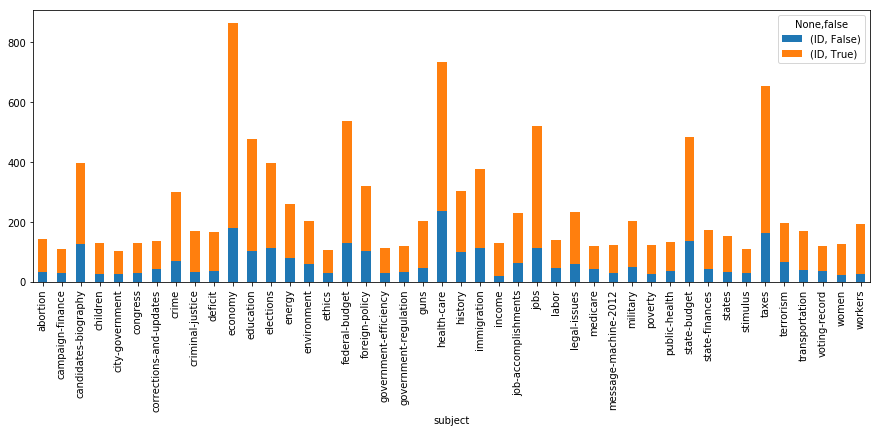

In [14]:
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

In [15]:
def normalize_tf(df, column):
    bd_norm = df.reset_index()
    bd_norm = bd_norm.set_index([column,'false'])['ID'].unstack(fill_value=0)

    row_sums = bd_norm.sum(axis=1)
    for row_ind in range(len(bd_norm.index)):
        bd_norm.iloc[row_ind] /= row_sums[row_ind]

    bd_norm = bd_norm.stack().reset_index(name='Percent').set_index([column, 'false'])
    return bd_norm

bd_norm = normalize_tf(tf_breakdown, 'subject')
bd_norm.head()

Percent
subject              false          
abortion             False  0.234043
                     True   0.765957
campaign-finance     False  0.277778
                     True   0.722222
candidates-biography False  0.314861

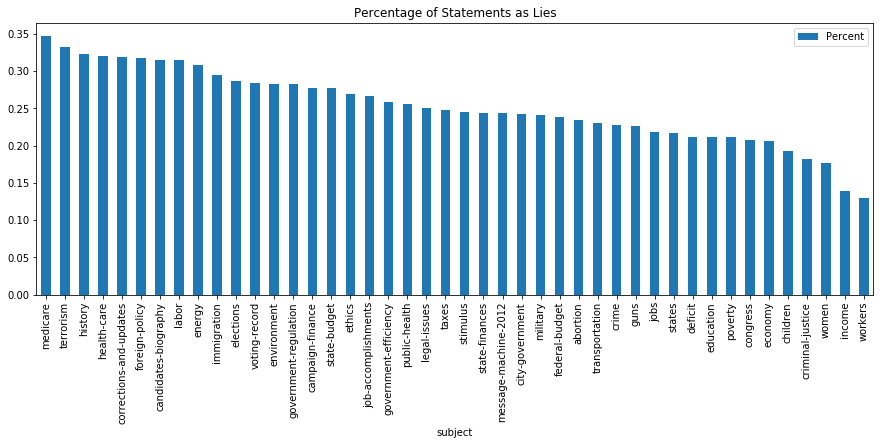

In [16]:
def plot_truthfulness(df, column):
    df_ri = df.reset_index()
    tf = df_ri[~df_ri['false']][[column, 'Percent']]
    tf = tf.sort_values('Percent', ascending=False)
    tf.plot(x=column,kind='bar', title="Percentage of Statements as Lies", figsize=(15,5))
    
plot_truthfulness(bd_norm, "subject")

### Task 1: Interpretation
We note that of the topics discussed often in the liar dataset, medicare and terrorism have the most lies. While we note the percentages are quite high, we note that statements from this dataset are by dy default disputed so this is not unexpected. However, assuming the dataset was not gathered with a particularly subject bias, the relative truth rate between subjects could be meaningful. It is possibly worth looking in to Note that this analysis does not consider consider half-true as a lie.

## Task 2: Explore speaker feature
We want to answer some basic questions about the speaker feature. This might expose interesting topics to analyze in greater depth because it is likely that different speakers have different levels of truthfulness. This creates multiple descriptive sub-tasks. We break this task down into the follow sub-tasks:
- Find all unique speakers. How many different speakers are there?
- Find which speakers have more than 50 instances within the dataset.
- Find a way to visualize how truth relates to this feature.

In [17]:
speakers_df = df_raw.copy()
speakers = speakers_df['speaker'].unique()
print("There are %d unique speakers" % len(speakers))
print("Some sample speakers include:\n", speakers[:5])

There are 2911 unique speakers
Some sample speakers include:
 ['dwayne-bohac' 'scott-surovell' 'barack-obama' 'blog-posting'
 'charlie-crist']


In [18]:
speakers_cts = speakers_df.groupby("speaker").statement.count()
speakers = speakers_cts[speakers_cts > 50]
print("There are %d unique speakers who appear more than 50 times within the dataset" % len(speakers))
print("Some sample speakers include:\n", speakers[:5])

There are 21 unique speakers who appear more than 50 times within the dataset
Some sample speakers include:
 speaker
barack-obama     488
bernie-s          88
blog-posting      59
chain-email      142
charlie-crist     70
Name: statement, dtype: int64


In [19]:
## Limit ourselves to only prominent speakers for visualization
speakers_df = speakers_df[speakers_df['speaker'].isin(speakers.keys())]

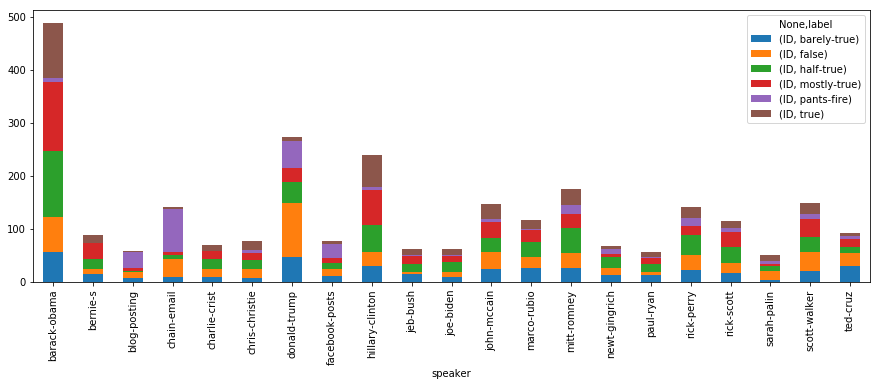

In [20]:
breakdown = by_label(speakers_df, 'speaker')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

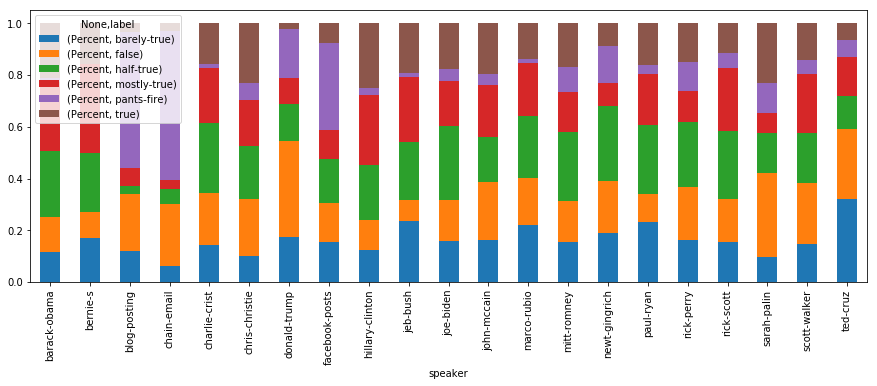

In [21]:
bd_norm = normalize(breakdown, 'speaker')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

From this, we can see a few interesting findings. It seems that Facebook posts, chain emails and Donald Trump are trastically more likely to be 'pants-fire' lies, which are the most obvious and blatantly false types of lies of the possible labels. We also see that most other speakers maintain a very much smaller 'pants-fire' rate.

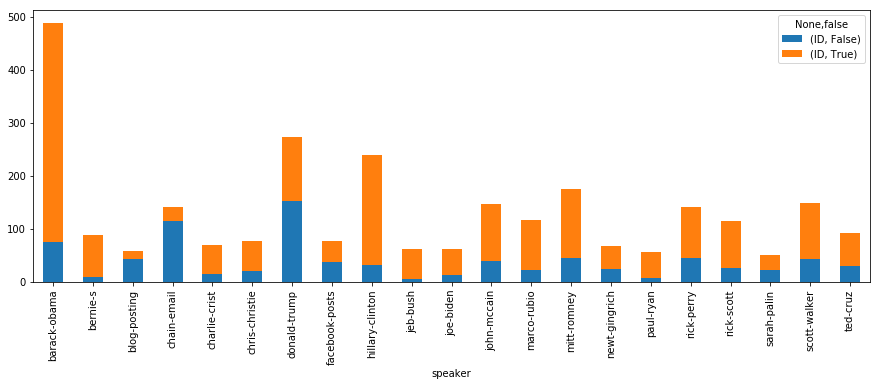

In [22]:
tf_breakdown = transform_tf(speakers_df, 'speaker')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

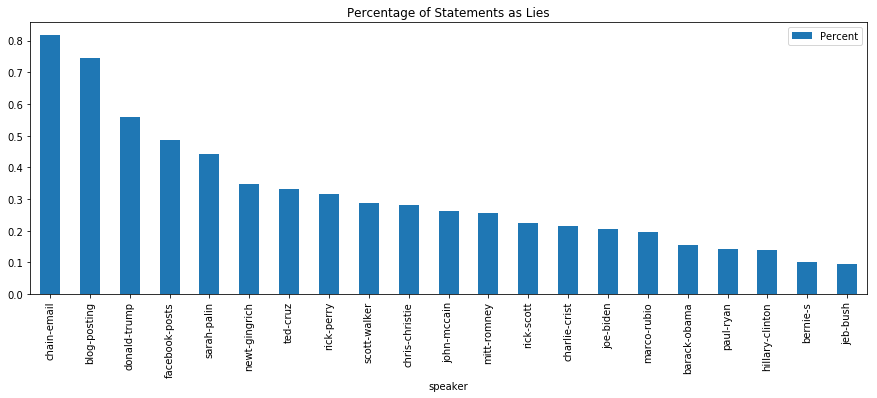

In [23]:
bd_norm = normalize_tf(tf_breakdown, 'speaker')
plot_truthfulness(bd_norm, 'speaker')

### Task 2: Interpretation
In breaking down our dataset by the speakers, we see some interesting trends, due to the fact that speakers can be both people as well as websites/communication mediums. In looking at our most prominent sources, we see that anonymous media tend to have the highest untruthfulness rate. The only person who who lies more than one of the anonymous media is Donald Trump, whose overall rate of lying is greater than Facebook posts. That said, we also see that Facebook posts proportionally are more 'pants-fire' type lies. Donald Trump has proportionally fewer 'pants-fire' lies, but drastically more 'false' lies.

We also note that chain-emails are heinously untruthful. Of the ones examined in this dataset, over 80% are either false or 'pants-fire' false.

## Task 3: Locational analysis
We note that our dataframe has state information for each of the statements. We would like to see how the rate of lies varies within states by:
- Creating a heatmap of lies from the dataset.

In [24]:
# Computing percentage of lies

states_lies_count = df_raw[df_raw.label.isin(["false", "pants-fire"])].groupby('state').state.count()
states_count = df_raw.groupby('state').state.count()
states_tot_false = pd.concat([states_count, states_lies_count], axis=1, sort=True).dropna()
states_tot_false.columns = ['count_tot', 'count_false']
states_tot_false.count_false = states_tot_false.count_false.astype('int64')
states_tot_false['perc_lies'] = (states_tot_false.count_false / states_tot_false.count_tot) * 100
states_tot_false.reset_index(inplace=True)
states_tot_false.columns = ['state', 'count_tot', 'count_false', 'perc_lies']
states_tot_false.head()

,state,count_tot,count_false,perc_lies
0,Alabama,14,4,28.571429
1,Alaska,65,28,43.076923
2,Arizona,182,47,25.824176
3,Arkansas,84,14,16.666667
4,California,159,42,26.415094


In [25]:
state_geo_path = r'us-states.json'
geo_json_data = json.load(open(state_geo_path))

get_state_names = lambda x: x['properties']['name']
geo_states = set(map(get_state_names, geo_json_data['features']))
df_states = set(states_tot_false['state'])
to_add = geo_states - df_states

In [26]:
us_map = folium.Map(location=[48, -102], zoom_start=3)
us_map.choropleth(geo_data=geo_json_data, data=states_tot_false,
             columns=['state', 'perc_lies'],
             key_on='feature.properties.name',
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Percentage of lies (%)')
us_map

### Task 3: Interpretation
From here we see lies being more prominent in Montana than anywhere else, while Tennessee, Mississippi, West Virginia also are prominent. Ultimately, we do not see much geographical clustering, and even if we thought to note the general trend for higher lie rate in southern states, this does not seem to hold very well considering Arkansas and North Carolina. This may ultimately just be a heatmap of the states of the political speakers within the dataset, so this may not be useful in our further analysis.

## Task 4: Explore job feature
The dataframe contains jobs of each of the speakers. We will perform similar analysis as with our other features, in order to see how well job analysis relates to truthfulness:
- Find all unique jobs. How many different subjects are there?
- Find a way to visualize how truth relates to this feature.

In [78]:
jobs_df = df_raw.copy()
jobs = jobs_df['job'].unique()
print("There are %d unique jobs" % len(jobs))
print("Some sample jobs include:\n", jobs)

There are 1185 unique jobs
Some sample jobs include:
 ['State representative' 'State delegate' 'President' ...
 'Environmental Defense Fund vice president of energy program, director of Texas regional office'
 'Chairman of the Council of Economic Advisers'
 'President, The Whitman Strategy Group']


Similar to above, there are too many unique jobs to query. So we will look at the most common jobs.

In [57]:
job_cts = jobs_df.groupby("job").statement.count()
jobs = job_cts[job_cts > 20]
print("There are %d unique jobs who appear more than 20 times within the dataset" % len(jobs))
print("Some sample jobs include:\n", jobs[:5])

There are 52 unique jobs who appear more than 20 times within the dataset
Some sample jobs include:
 job
Attorney                                   81
Attorney General                           33
Businessman                                34
Candidate for U.S. Senate and physician    39
Co-host on CNN's "Crossfire"               73
Name: statement, dtype: int64


In [58]:
## Limit ourselves to only prominent speakers for visualization
jobs_df = jobs_df[jobs_df['job'].isin(jobs.keys())]

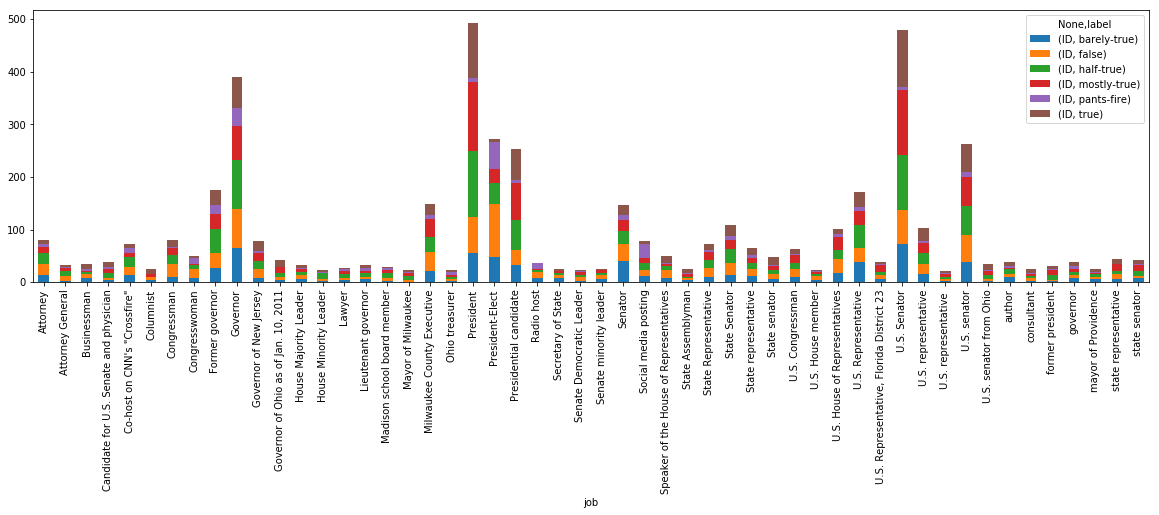

In [59]:
breakdown = by_label(jobs_df, 'job')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(20,5))

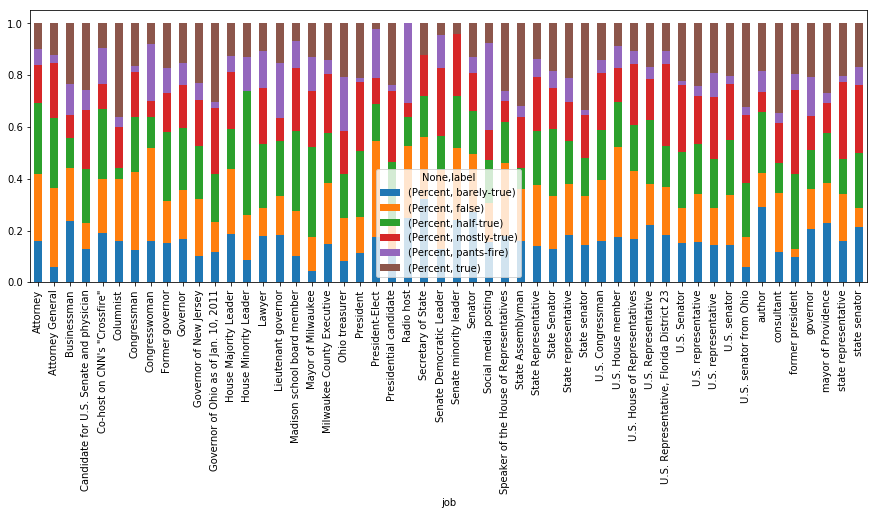

In [60]:
bd_norm = normalize(breakdown, 'job')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

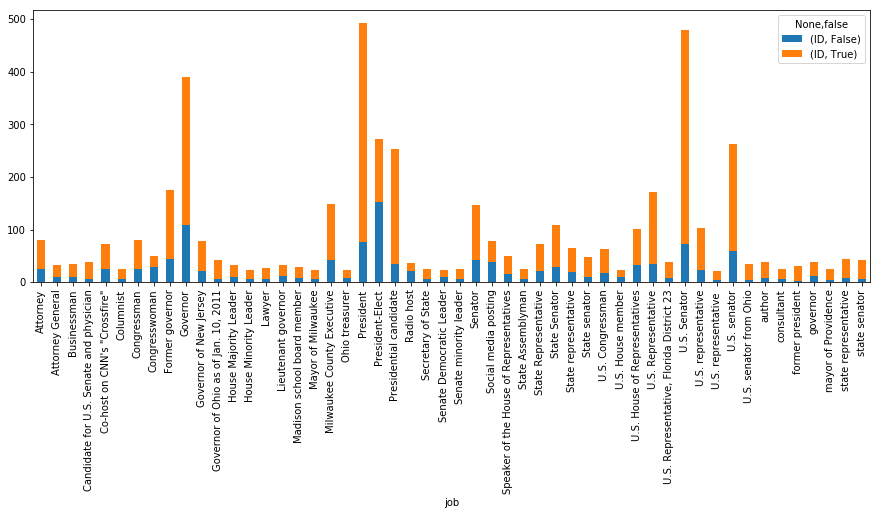

In [64]:
tf_breakdown = transform_tf(jobs_df, 'job')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

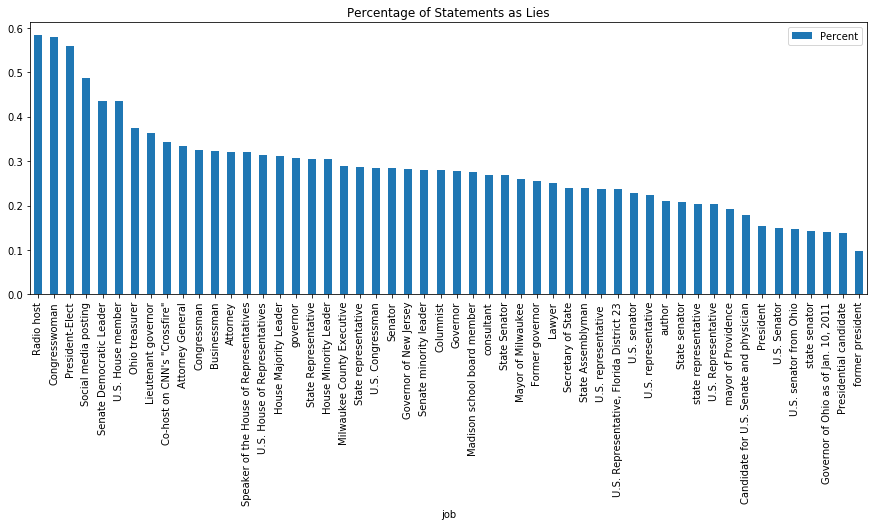

In [65]:
bd_norm = normalize_tf(tf_breakdown, 'job')
plot_truthfulness(bd_norm, 'job')

### Task 4: Interpretation
This analysis must be interpreted with knowledge of the time constraints of the dataset. In the years 2007-2017, there were only two President-Elects, one of whom is one of the most consistent liars as shown in the analysis above. Additionally, congresswoman may only refer to a very small number of people within the dataset. This can be said for many of the jobs, such as Ohio treasurer and House Majority Leader.

It is notable that Radio hosts, businessmen and attorneys are all fairly generic jobs that have high instances of falsehoods in this dataset.

## Task 5: Explore the party feature
Using similar analysis as above, we will explore one other relevant feature within the dataset, which is political party affiliation:
- Find a way to visualize how truth relates to this feature.

In [79]:
parties_df = df_raw.copy()
parties = jobs_df['party'].unique()
print("There are %d unique parties" % len(parties))
print("Some sample parties include:\n", parties)

There are 24 unique parties
Some sample parties include:
 ['republican' 'democrat' 'none' 'organization' 'independent' 'columnist'
 'activist' 'talk-show-host' 'libertarian' 'newsmaker' 'journalist'
 'labor-leader' 'state-official' 'business-leader' 'education-official'
 'tea-party-member' nan 'green' 'liberal-party-canada' 'government-body'
 'Moderate' 'democratic-farmer-labor' 'ocean-state-tea-party-action'
 'constitution-party']


In [86]:
parties_cts = parties_df.groupby("party").statement.count()
parties = parties_cts[parties_cts > 20]
print("There are %d unique affiliations who appear more than 20 times within the dataset" % len(parties))
print("Some sample affiliations include:\n", parties[:5])

There are 11 unique affiliations who appear more than 20 times within the dataset
Some sample affiliations include:
 party
activist         39
columnist        35
democrat       3336
independent     147
journalist       38
Name: statement, dtype: int64


In [91]:
## Limit ourselves to only prominent speakers to remove edge cases
parties_df = parties_df[parties_df['party'].isin(parties.keys())]

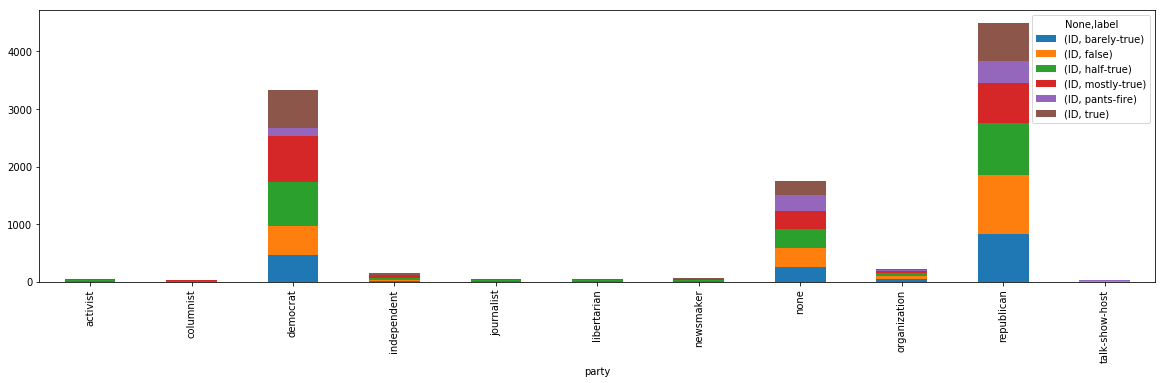

In [92]:
breakdown = by_label(parties_df, 'party')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(20,5))

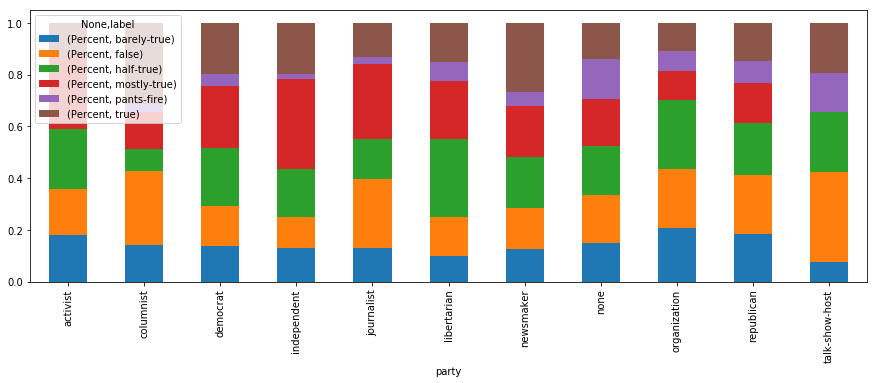

In [93]:
bd_norm = normalize(breakdown, 'party')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

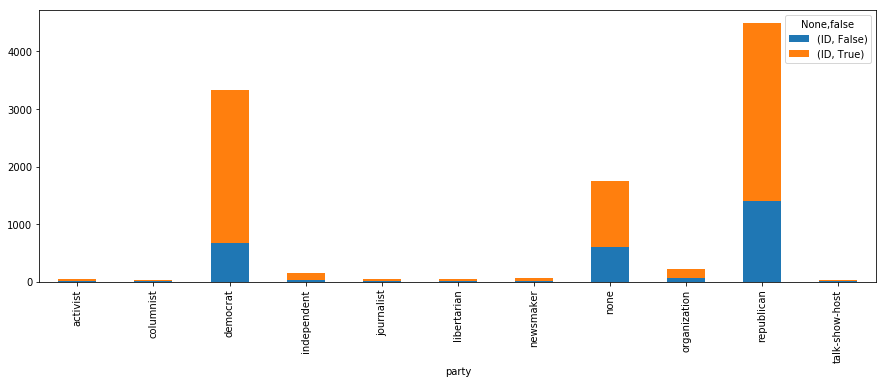

In [94]:
tf_breakdown = transform_tf(parties_df, 'party')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

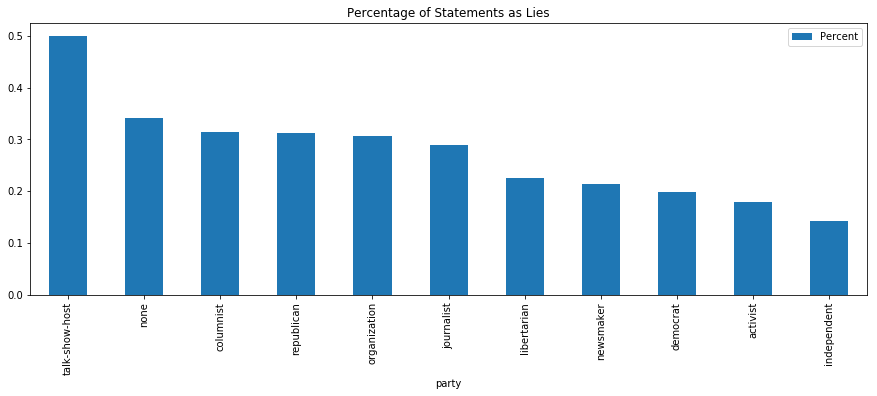

In [95]:
bd_norm = normalize_tf(tf_breakdown, 'party')
plot_truthfulness(bd_norm, 'party')

### Task 5: Interpretation
This task has some interesting results. Extreme values seem to be dominated not by the standard two American political parties. We see talk-show-host being by far the least truthful affiliation. This is interesting because talk shows very often have a political bias, but for purposes of this dataset they are not strictly affiliated. This also shows that this feature has a lot of redundance with the features above - job and speaker often define party affiliation.

## Task 6: Measure interaction between affiliation and job
Prior to this point, we have performed single variable analysis of the features within the dataset. Here we will begin looking at interactions between features. In this task, we want to analyze and visualize how the features interact. We do so by:
- Finding the jobs with the highest rate of lies.
- Finding the parties with the highest rate of lies.
- Find the job/party combinations with the highest rate of lies.
- Breakdown and visualize the effect party has on truthfulness for each of the high lie rate jobs.

In [97]:
# Capture jobs with more lies
job_false = df_raw[df_raw.label.isin(["false", "pants-fire"])].groupby("job").ID.count()
job_false_df = pd.DataFrame(job_false).reset_index()
job_false_df.columns = ['job', 'false_count']
job_false_df_max = job_false_df.sort_values(by='false_count' ,ascending=False).head(20)

In [98]:
# Capture parties with more lies
party_false = df_raw[df_raw.label.isin(["false", "pants-fire"])].groupby("party").ID.count()
party_false_df = pd.DataFrame(party_false).reset_index()
party_false_df.columns = ['party', 'false_count']
party_false_df_max = party_false_df.sort_values(by='false_count' ,ascending=False).head(20)

In [101]:
# Analyze both at the same time
party_job_false = df_raw[df_raw.label == "false"].groupby(["job", "party"]).ID.count()
party_job_false_df = pd.DataFrame(party_job_false).reset_index()
party_job_false_df.columns = ['job', 'party', 'false_count']
party_job_false_df_sorted = party_job_false_df.sort_values(by='false_count' ,ascending=False)

In [102]:
merge_party_job = party_job_false_df_sorted.merge(party_job_false_df_sorted, on='job')
merge_party_job = merge_party_job[(merge_party_job.party_x == 'republican') & (merge_party_job.party_y == 'democrat')]
merge_party_job = merge_party_job.sort_values(by='false_count_x', ascending=False)
data_matrix = merge_party_job.iloc[:4]
data_matrix

,job,party_x,false_count_x,party_y,false_count_y
2,Governor,republican,68,democrat,7
10,U.S. senator,republican,37,democrat,14
14,U.S. Senator,republican,36,democrat,21
24,Senator,republican,30,democrat,2


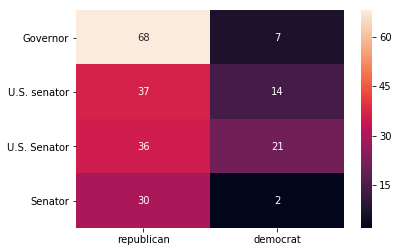

In [103]:
sns.heatmap(np.matrix(data_matrix[['false_count_x', 'false_count_y']]), annot=True, fmt="d", xticklabels=['republican', 'democrat'], yticklabels=data_matrix['job'])

It appears as though republican governors have drastically higher rate of lying than democrats. We observed before that republicans had only a marginally higher lying rate. So we want to see if the recorded governor statements themselves lean toward statements from republican governors.

In [116]:
governors = jobs_df[jobs_df['job']=='Governor']
governors[['speaker', 'job', 'party']].drop_duplicates().head()

,speaker,job,party
33,rick-scott,Governor,republican
50,rick-perry,Governor,republican
53,andrew-cuomo,Governor,democrat
70,terry-mcauliffe,Governor,democrat
171,pat-quinn,Governor,democrat


In [117]:
governors.groupby('party').job.count()

party
democrat       54
republican    337
Name: job, dtype: int64

### Task 6: Interpretation
In this task we see some possible interaction between the features. We noted earlier that the rate of lies was higher for Republicans than democrats, but this seems especially pronounced for governors. This leads us to question whether or not there simply tend to be more republican governors sampled than democrats. This ends up being the case, with over 6 times the amount of statements taken from republican governors than democratic governors. This reveals a bias within the sampling of the dataset which we must be careful for when constructing models or trying to make future analysis.

## Task 7: Create a rudimentary model
For this project, we will ultimately be using the findings above as well as additional tools to augment our dataset for underlying features. We will make an initial model in the exploration step simply to establish a baseline from which to improve.

While it is notable that this is not simply a machine learning exercise, we believe that improvement of the model can be some indication of relevance of the additionally analysis we perform in augmenting the data set to expose new relations that can hopefully be predictive.

In [67]:
def preprocess_data(data):
    subject_split = data.copy()
    subject_split["subject"] = df_raw["subject"].apply(lambda x : str(x).lower().split(","))
    subjects = subject_split.subject.apply(pd.Series)
    new_cols = cols.copy()
    new_cols.remove("subject")

    ## Now merge with original frame to create separate columns for each subject
    ## Then melt so that each entry exists under several subjects
    subject_split = subjects.merge(subject_split, right_index = True, left_index = True).drop(["subject"], axis = 1).melt(id_vars = new_cols, value_name = "subject").drop("variable", axis = 1).dropna()
    
    # Manually cleaning state field
    subject_split['state'] = subject_split['state'].apply(lambda x: "Washington" if x == "Washington, D.C." or x == "Washington, D.C. " or x == "Washington state" or x == "Washington DC" or x == "Washington D.C." else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Wisconsin" if x == "Wisconsin " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Ohio" if x == "ohio" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "New York" if x == "New York " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Illinois" if x == "Illinois " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Georgia" if x == "Georgia " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Florida" if x == "Florida " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Colorado" if x == "Colorado " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Massachusetts" if x == "Massachusetts " else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Pennsylvania" if x == "PA - Pennsylvania" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Tennessee" if x == "Tennesse" else x)
    subject_split['state'] = subject_split['state'].apply(lambda x: "Virginia" if x == "Virgiia" or x == "Virgina" or x == "Virginia " or x == "Virginia director, Coalition to Stop Gun Violence" else x)
    
    # Cleaning context field
    subject_split['context'] = subject_split['context'].apply(lambda x: "a speech" if x == "a speech." or x == "in a speech" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television interview" if x == "a TV interview" or x == "a TV interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a debate" if x == "a debate." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a radio interview" if x == "a radio interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "an interview" if x == "an interview." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television commercial" if x == "a TV commercial" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a television ad" if x == "a TV ad." or x == "a TV ad" else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a press release" if x == "a press release." else x)
    subject_split['context'] = subject_split['context'].apply(lambda x: "a news release" if x == "a news release." else x)
    
    # Cleaning job field
    subject_split['job'] = subject_split['job'].apply(lambda x: "Governor" if x == "governor" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "U.S. Senator" if x == "U.S. senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "U.S. Representative" if x == "U.S. representative" or x == "U.S. House of Representatives" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Representative" if x == "State representative" or x == "state representative" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" or x == "state senator" else x)
    subject_split['job'] = subject_split['job'].apply(lambda x: "State Senator" if x == "State senator" or x == "state senator" else x)
    
    return subject_split

In [70]:
# Loading data and preprocessing
data = df_raw.copy()

clean_data = preprocess_data(data)

In [71]:
# Converting in categorical variables and factorizing label

dataset = clean_data.drop(columns=["ID", "statement"])
factor = pd.factorize(dataset['label'])
dataset.label = factor[0]
definitions = factor[1]

dummy_dataset = pd.get_dummies(dataset)

In [72]:
# Splitting data 

X = dummy_dataset.iloc[:,1:].values
y = dummy_dataset.iloc[:,0].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [73]:
# Standardizing data

std_scaler = StandardScaler()
X_tr = std_scaler.fit_transform(X_tr)
X_te = std_scaler.transform(X_te)

In [74]:
# Training and de-factorization

classifier = RandomForestClassifier(n_estimators = 500)

classifier.fit(X_tr, y_tr)

probs = classifier.predict(X_te)

reversefactor = dict(zip(range(5),definitions))

y_true = np.vectorize(reversefactor.get)(y_te)

y_pred = np.vectorize(reversefactor.get)(probs)

In [75]:
# Confusion matrix
pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,None,barely-true,false,half-true,mostly-true,true
Actual,,,,,,
None,142,7,39,32,16,13
barely-true,10,373,62,52,37,31
false,9,40,479,52,62,23
half-true,12,40,66,556,91,42
mostly-true,12,33,51,57,545,54
true,9,43,52,56,60,395


In [76]:
# Accuracy
accuracy_score(y_true, y_pred)

0.6816315357240624

In [77]:
# F1 score
f1_score(y_true, y_pred, average="micro")

0.6816315357240624

### Task 7: Interpretation
Our rudimentary model has much better than random accuracy in classifying the testing data, especially given that this dataset exists in 6 classes, rather than being a binary classification. That said, the accuracy is still not exceptional.

## Task 8: Date tracking
Each of the entries of the dataset is accompanied with a corresponding json ID. Because all of these are sampled from Politifacts, we can query to find more information. In this task we:
- Create a routine to query Politifacts for dates for each entry.
- Visualize the findings.

Because querying takes a large amount of time, we will perform this only on a subset initially.

In [177]:
df = df_raw.iloc[0:100]

id_col = df.ID.str[:-5]

dicts = []
for i in id_col.values:
    url = 'https://www.politifact.com/api/v/2/statement/' + i + '/?format=json'
    r = requests.get(url)
    dicts.append(r.json())

In [178]:
dates = list(map(lambda x: x['statement_date'], dicts))
year = list(map(lambda x: x[:4], dates))

In [179]:
df['year'] = year

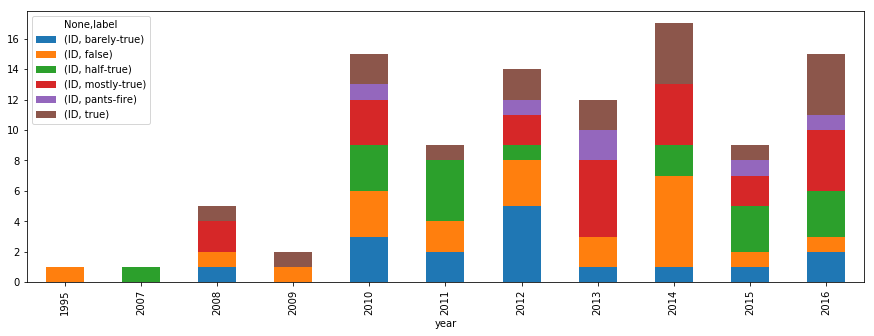

In [180]:
breakdown = by_label(df, 'year')
breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

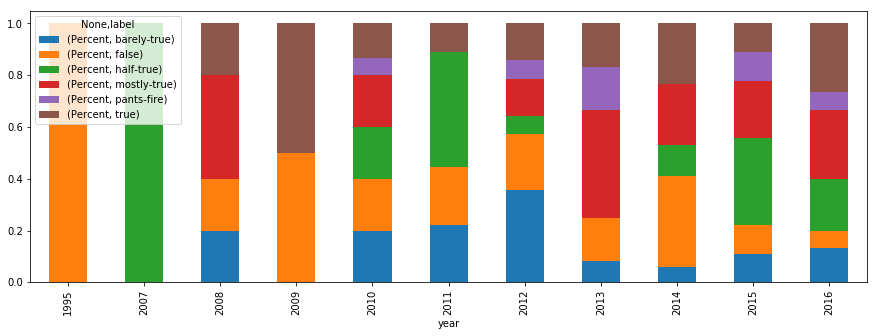

In [181]:
bd_norm = normalize(breakdown, 'year')
bd_norm.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

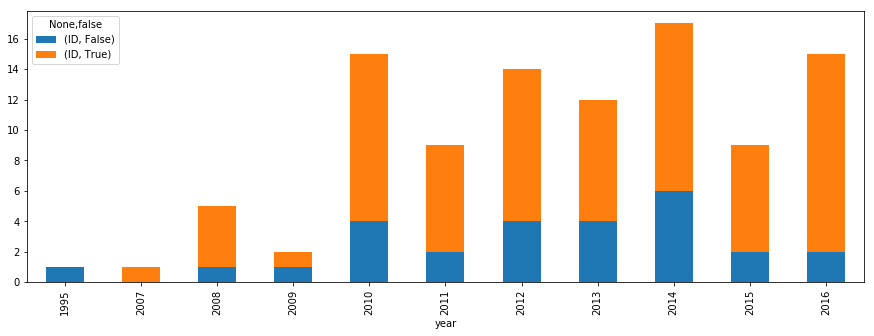

In [182]:
tf_breakdown = transform_tf(df, 'year')
tf_breakdown.unstack().plot(kind='bar', stacked=True, figsize=(15,5))

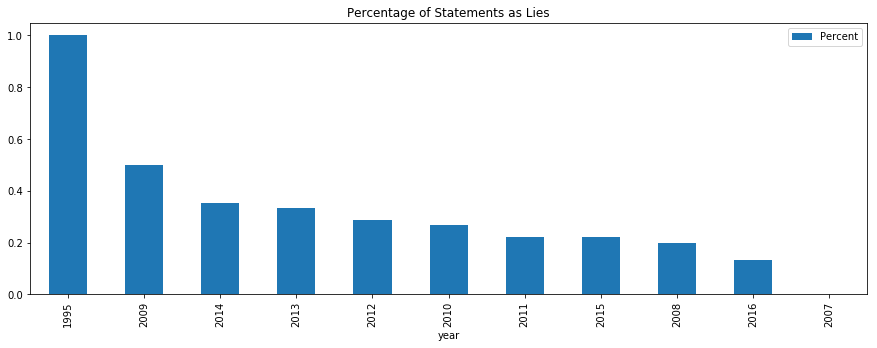

In [184]:
bd_norm = normalize_tf(tf_breakdown, 'year')
plot_truthfulness(bd_norm, 'year')

### Overall Interpretations

In this notebook, we have gathered insights to proceed in augmenting the data set. In the future, we will see if augmentations can help improve this accuracy (indicating that underlying features might be important in discrimination of the data) as well try to see how generalizable these findings are to other datasets. In specific, we note that the topic, speaker and party each seemed to be reasonable predictive features. We have noted in many places that anonymity seemed to increase lack of truthfulness. Additionally, we found that the location of the statement did not seem to be a particularly strong indicator as most location trends seemed to only hold in certain cases. We also found some inherent biases in the collection of the dataset, whereby some job statements were sampled much higher for republicans than democrats. This would lead a classifier, such as the rudimentary classifier we build, to associate certain jobs with lack of truthfulness, even if it is the result of a sampling bias, or possibly reflective of a disparity of representations in that job role.

One of the only columns we did not explore was in the statement itself. This is not an easily parsible column, as each statement will tend to only appear once. To analyze this feature we will need to perform some NLP tasks to see if some linguistic aspects of the statement can be interpreted to predictive features.